In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━

In [3]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [4]:
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
from google.colab import userdata
key = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=key)
project = rf.workspace("aerial-person-detection").project("aerial-person-detection")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Aerial-Person-Detection-3 in coco:: 100%|██████████| 6994/6994 [00:11<00:00, 594.37it/s]


In [7]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)

print(f"Train size: {len(ds_train)}")
print(f"Valid size: {len(ds_valid)}")

Train size: 6443
Valid size: 545


In [9]:
IMAGE_SIZE = 480

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

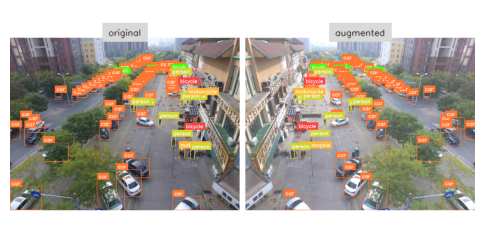

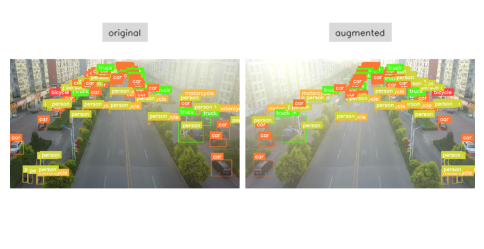

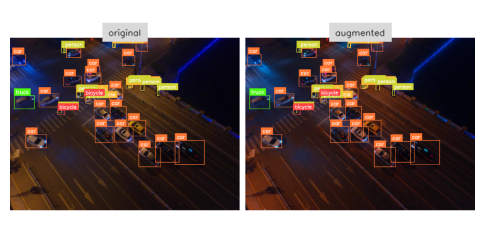

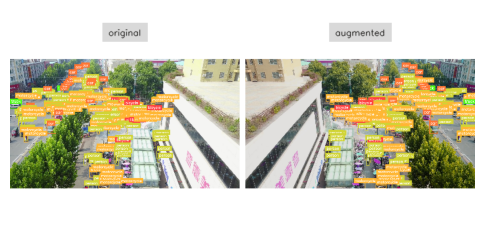

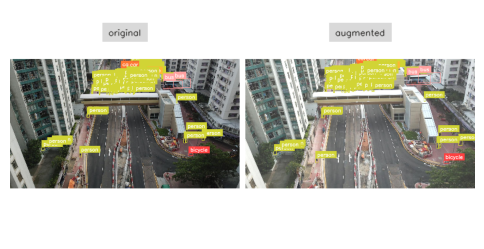

In [20]:
def annotate(image, annotations, classes):
    labels = [
        classes[class_id]
        for class_id
        in annotations.class_id
    ]

    bounding_box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator(text_scale=1, text_thickness=2)

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels=labels)
    return annotated_image


IMAGE_COUNT = 5

for i in range(IMAGE_COUNT):
    _, image, annotations = ds_train[i]

    output = train_augmentation_and_transform(
        image=image,
        bboxes=annotations.xyxy,
        category=annotations.class_id
    )

    augmented_image = output["image"]
    augmented_annotations = replace(
        annotations,
        xyxy=np.array(output["bboxes"]),
        class_id=np.array(output["category"])
    )

    annotated_images = [
        annotate(image, annotations, ds_train.classes),
        annotate(augmented_image, augmented_annotations, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['original', 'augmented'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

In [21]:
class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

In [25]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)

In [26]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

In [27]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

In [28]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.

In [29]:
training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=16,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=300,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dima-yanyshev (dima-yanyshev-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 854.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 60.12 MiB is free. Process 3025 has 14.68 GiB memory in use. Of the allocated memory 13.53 GiB is allocated by PyTorch, and 1.01 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)